# Further applications: data augmentation for histological images
This notebook shows how the biscuit optimization problem can be applied to the problem of data augmentation, i.e. the generation of realistic synthetic data to improve the training of machine learning systems.

In particular, an heuristic will be applied to image augmentation in biomedical images, which benefit most from this
process as obtaining samples can be hard or very expensive.

Images are taken from a public dataset available at [https://www.kaggle.com/competitions/data-science-bowl-2018/data](https://www.kaggle.com/competitions/data-science-bowl-2018/data)

## Inputs

In this case, the dough mask is an empty 256×256 image and cutters are single nuclei cut from larger images.

In [19]:
# Optimization Project: Biscuit Optimizer
# Roberto Basla
# Politecnico di Milano
# A.Y. 2021/2022

import os
import numpy as np
from pprint import pprint

import cv2
from typing import Any, Callable, Generator
from time import time
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageFilter

import sys
sys.path.append("..")
from utils import utils

## Inputs

In [2]:
nuclei_dir = "../../img/nuclei/"
image_shape = (256, 256)

In [3]:
samples = {}
for id in os.listdir(nuclei_dir):
	sample = {}
	masks_path = os.path.join(nuclei_dir, id,  "masks")
	image_path = os.path.join(nuclei_dir, id, "images")

	sample["image"] = cv2.imread(os.path.join(image_path, id + ".png"), cv2.IMREAD_GRAYSCALE)
	assert sample["image"] is not None, f"{id}, {os.path.join(image_path, id + '.png')}"
	masks = []
	for mask_filename in os.listdir(masks_path):
		masks.append(cv2.imread(os.path.join(masks_path, mask_filename), cv2.IMREAD_GRAYSCALE) > 0)
		assert masks[-1] is not None, f"{id}, {mask_filename}"
	sample["masks"] = np.stack(masks, axis=0)
	samples[id] = sample

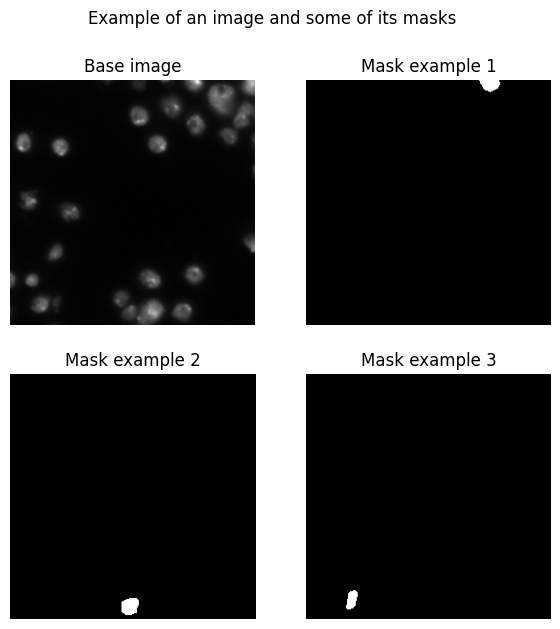

In [18]:
sample = list(samples.values())[0]
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0, 0].imshow(sample["image"], cmap="gray")
ax[0, 0].set_title("Base image")
ax[0, 0].axis('off')
masks = list(sample["masks"])
ax[0, 1].imshow(masks[0], cmap="gray")
ax[0, 1].set_title("Mask example 1")
ax[0, 1].axis('off')
ax[1, 0].imshow(masks[1], cmap="gray")
ax[1, 0].set_title("Mask example 2")
ax[1, 0].axis('off')
ax[1, 1].imshow(masks[2], cmap="gray")
ax[1, 1].set_title("Mask example 3")
ax[1, 1].axis('off')
fig.suptitle("Example of an image and some of its masks")
plt.show()

## Nuclei heuristics

In [22]:
def enlarge_mask(mask: np.array, n_times: int) -> np.array:
	"""
	Enlarges the given mask by setting to 1 all pixels where the gradient is not 0 for n_times
	Args:
		mask: The binary mask to modify
		n_times: The number of times to enlarge the mask
	Returns:
		The modified mask
	"""
	for i in range(n_times):
		mask = np.where(np.logical_or(*np.gradient(mask * 1)), 1, mask)
	return mask

def shrink_mask(mask: np.array, n_times: int) -> np.array:
	"""
	Shrinks the given mask by setting to 0 all pixels where the gradient is not 0 for n_times
	Args:
		mask: The binary mask to modify
		n_times: The number of times to shrink the mask
	Returns:
		The modified mask
	"""
	for i in range(n_times):
		new_mask = np.where(np.logical_or(*np.gradient(mask * 1)), 0, mask)
		if np.count_nonzero(new_mask) == 0:
			# The mask is not updated if it would be deleted
			return mask
		mask = new_mask
	return mask

def modify_margin(mask: np.array, delta: int):
	"""
	Applies the given delta to the mask
	Args:
		mask: The binary mask to modify
		delta: Difference of margin for the new mask
	Returns:
		The modified mask
	"""
	if delta == 0:
		return mask
	if delta > 0:
		return enlarge_mask(mask, delta)
	return shrink_mask(mask, -delta)

In [53]:
def generate_from_samples(samples, image_shape, margin_range=None):
	"""
	Generates an artificial image given the samples
	Args:
		samples: Images and masks to reuse for the new image
		image_shape: Shape of the produced image
		margin_range: Optional tuple of limit values for margin modification 
	"""
	# New image initialization
	nuclei_image = np.zeros(image_shape)
	bitmask = np.ones(image_shape)

	failed_counter = 0
	nuclei_masks = []

	mask_num = 1
	# The algorithm continues until it fails to position 5 nuclei in a row
	while failed_counter < 5:
		# Selects at random one image and one of its masks
		id = random.choice(list(samples.keys()))
		sample = samples[id]
		mask_id = random.randint(0, sample["masks"].shape[0] - 1)
		
		full_mask = sample["masks"][mask_id]
		original_mask = utils.crop_image(full_mask)

		# If needed, redefines the margin
		if margin_range is not None:
			full_mask = modify_margin(full_mask, random.randint(margin_range[0], margin_range[1]))
		
		mask = utils.crop_image(full_mask)
		y_diff = int((mask.shape[0] - original_mask.shape[0]) / 2)
		x_diff = int((mask.shape[1] - original_mask.shape[1]) / 2)

		y0, x0, y1, x1 = utils.crop_coordinates(sample["masks"][mask_id])
		cropped_image = sample["image"][y0:y1, x0:x1]
		# Check for feasible positions
		available_coords = tuple((h, k) for h in range(image_shape[0]) for k in range(image_shape[1]) \
			if utils.can_host(bitmask, mask, h, k))
		if len(available_coords) > 0:
			failed_counter = 0
			# Choose a random position
			n, m = random.choice(available_coords)
			bitmask[n:n+mask.shape[0], m:m+mask.shape[1]] = \
				np.logical_and(bitmask[n:n+mask.shape[0], m:m+mask.shape[1]], np.logical_not(mask))

			start_y = n + y_diff
			start_x = m + x_diff

			# Update the nuclei image
			old_patch = nuclei_image[max(start_y, 0):start_y+cropped_image.shape[0],
				max(start_x, 0):start_x+cropped_image.shape[1]]
			new_patch = np.where(original_mask, cropped_image, 0)[:old_patch.shape[0], :old_patch.shape[1]]
			nuclei_image[max(start_y, 0):start_y+cropped_image.shape[0], 
				max(start_x, 0):start_x+cropped_image.shape[1]] = np.where(np.logical_xor(old_patch, new_patch),
					old_patch + new_patch,
					np.average([old_patch, new_patch], axis=0)
				)

			# Add a mask to the stack
			mask_layer = np.zeros(image_shape)
			mask_layer[max(start_y, 0):start_y+cropped_image.shape[0], 
				max(start_x, 0):start_x+cropped_image.shape[1]] = np.where(original_mask, 1, 0)[:old_patch.shape[0], 
				:old_patch.shape[1]]
			nuclei_masks.append(mask_layer)

			mask_num += 1
		else:
			failed_counter += 1

	nuclei_image = np.where(nuclei_image == 0, np.random.normal(scale=4, size=image_shape), nuclei_image)
	nuclei_masks = np.stack(nuclei_masks)
	return nuclei_image, nuclei_masks

In [122]:
def show_augmentation(nuclei_image, nuclei_masks, title):
	print("Masks shape:", nuclei_masks.shape)
	# Adds a bit of blur for sharp edges derived from the segmentation
	plt.imshow(np.asarray(Image.fromarray(nuclei_image).convert("RGB").filter(ImageFilter.GaussianBlur(0.8))))
	plt.axis("off")
	plt.show()

	masks = np.transpose(nuclei_masks, axes=(1,2,0))
	colored_masks = np.sum(masks * [i + 10 for i in range(nuclei_masks.shape[0])], axis=2)

	plt.imshow(colored_masks, vmax=(nuclei_masks.shape[0] + 20))
	plt.axis("off")
	plt.show()

Masks shape: (181, 256, 256)


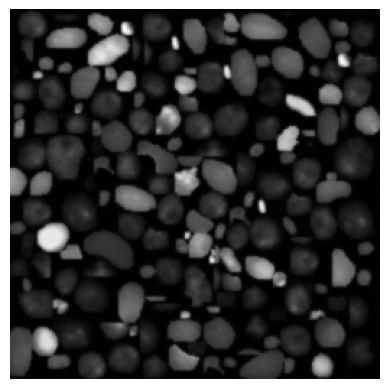

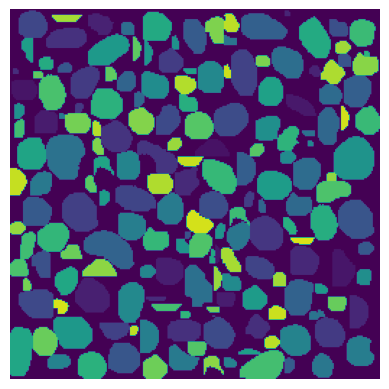

In [123]:
nuclei_image, nuclei_masks = generate_from_samples(samples, image_shape)
show_augmentation(nuclei_image, nuclei_masks, "Random strategy")

## Margin modifications

0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0 33


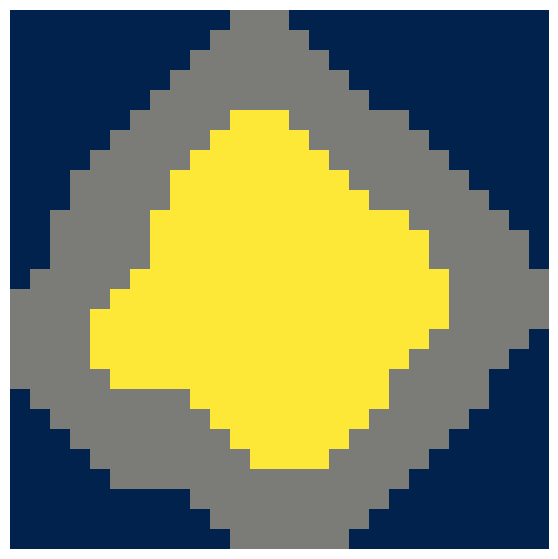

In [124]:
id = random.choice(list(samples.keys()))
sample = samples[id]
mask_id = random.randint(0, sample["masks"].shape[0] - 1)

full_mask = sample["masks"][mask_id]
print(id, mask_id)
processed_mask = modify_margin(full_mask, 5)
y0, x0, y1, x1 = utils.crop_coordinates(processed_mask)

mask = processed_mask[y0:y1, x0:x1]
original_mask = full_mask[y0:y1, x0:x1]

plt.figure(figsize=(7, 7))
plt.imshow(np.where(original_mask, 255, np.where(mask, 127, 0)), cmap="cividis")
plt.axis("off")
plt.show()

Masks shape: (196, 256, 256)


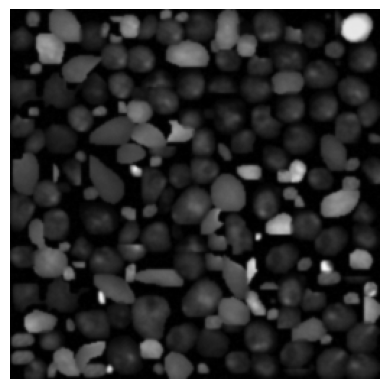

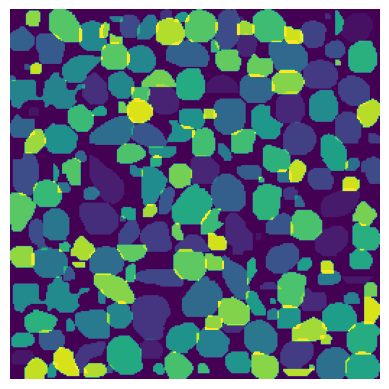

In [125]:
nuclei_image, nuclei_masks = generate_from_samples(samples, image_shape, margin_range=(-1, -1))
show_augmentation(nuclei_image, nuclei_masks, "Lowered margin")

Masks shape: (72, 256, 256)


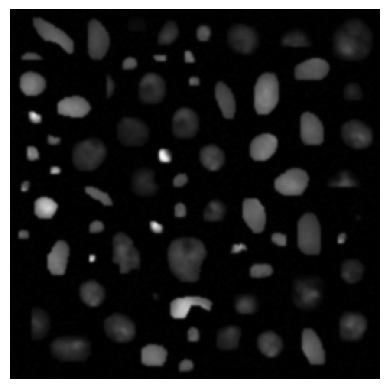

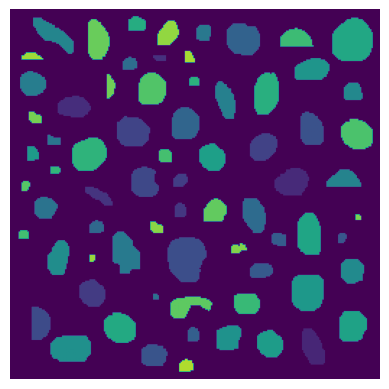

In [126]:
nuclei_image, nuclei_masks = generate_from_samples(samples, image_shape, margin_range=(5, 5))
show_augmentation(nuclei_image, nuclei_masks, "Increased margin")

Masks shape: (118, 256, 256)


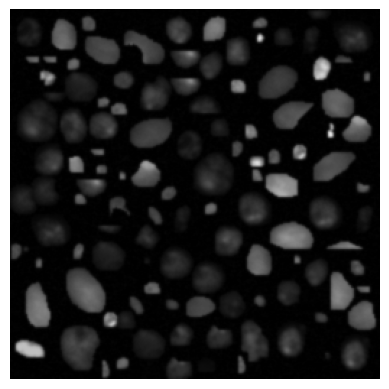

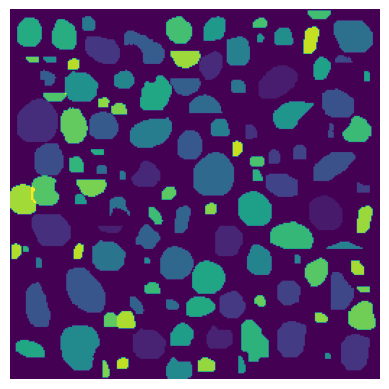

In [127]:
nuclei_image, nuclei_masks = generate_from_samples(samples, image_shape, margin_range=(-1, 5))
show_augmentation(nuclei_image, nuclei_masks, "Random margin")